[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Reading data in chunks...

What's in our dataset?
Total complaints: 9404047
Number of categories: 21


<Figure size 1200x600 with 0 Axes>

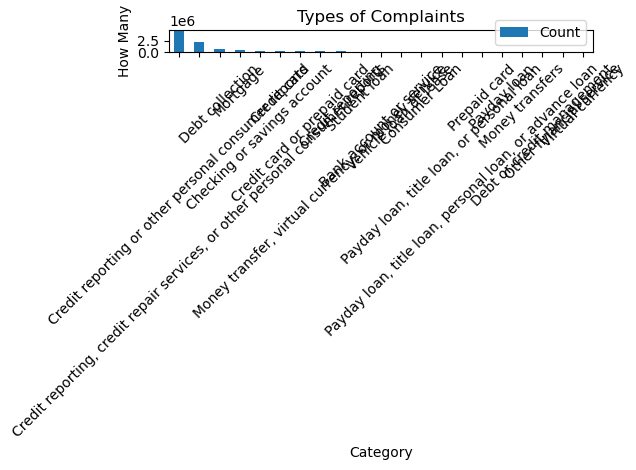

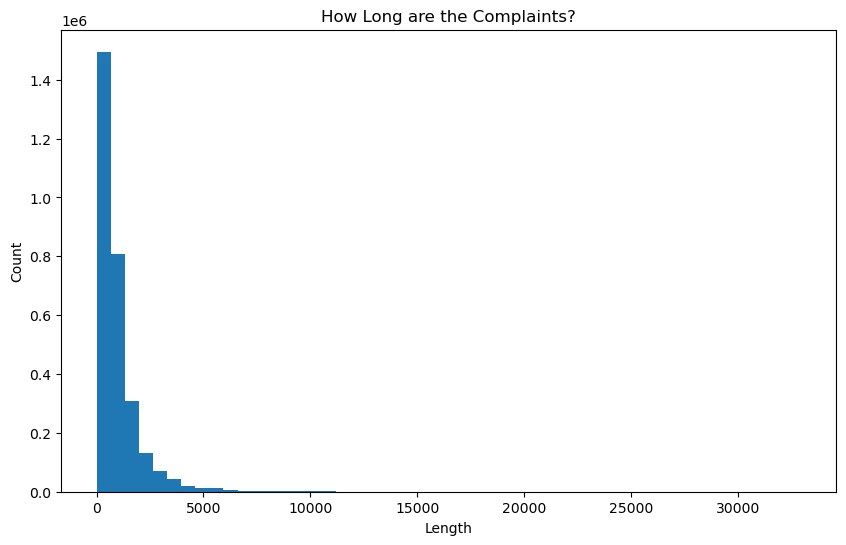

Average length: 1000.35 characters
Shortest: 4 characters
Longest: 32962 characters

Processing Credit reporting or other personal consumer reports...
Creating word cloud...


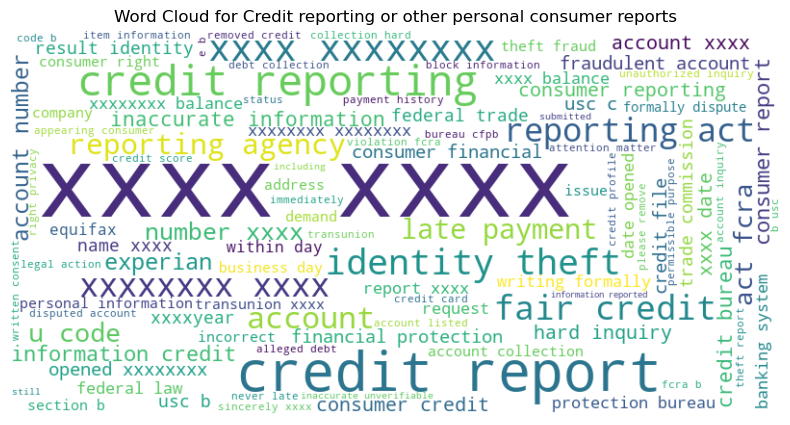

Showing common words...


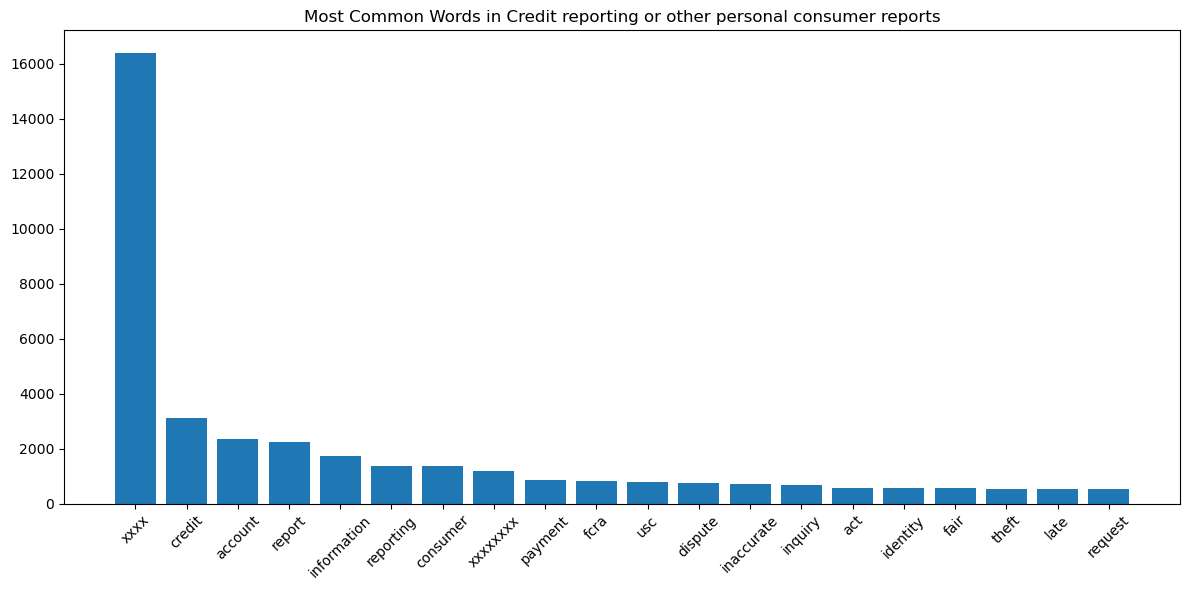


Processing Debt collection...
Creating word cloud...


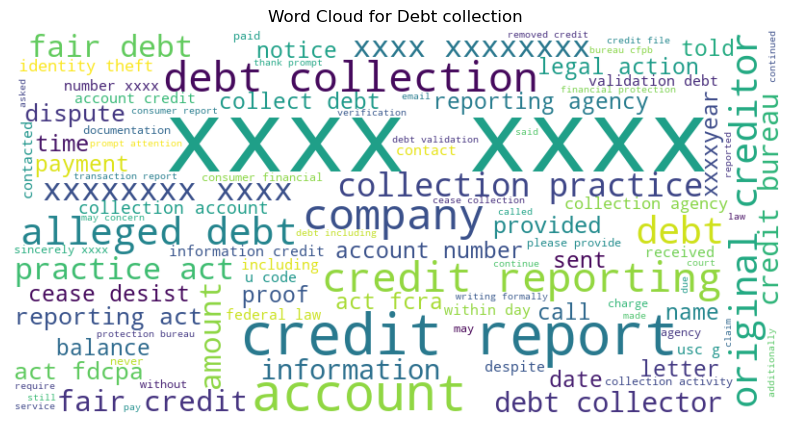

Showing common words...


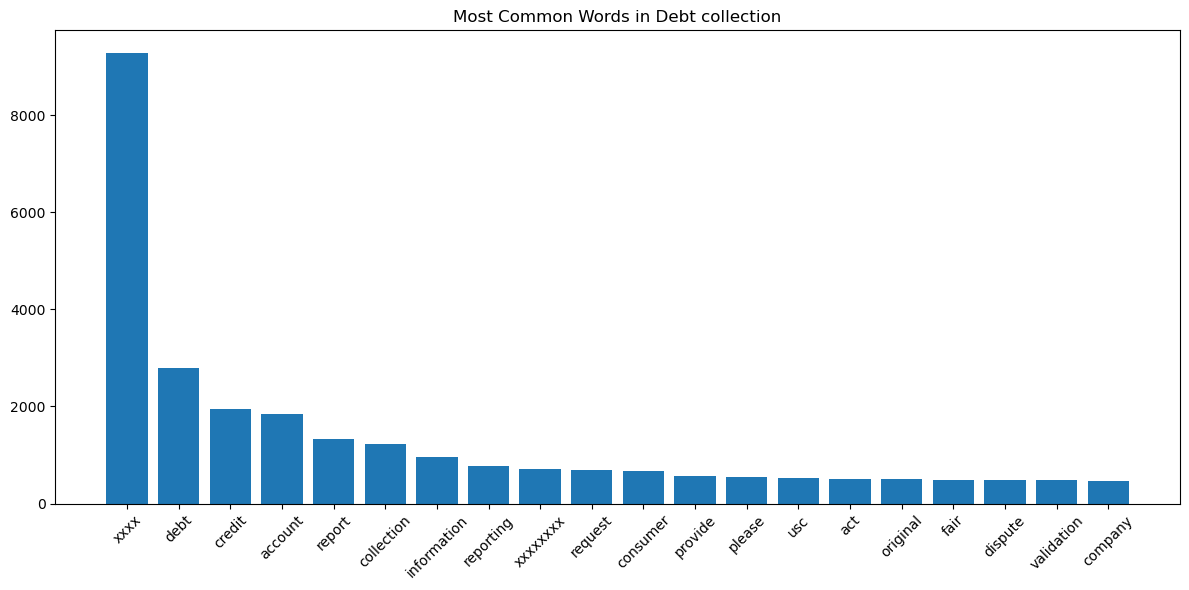


Processing Credit card...
Creating word cloud...


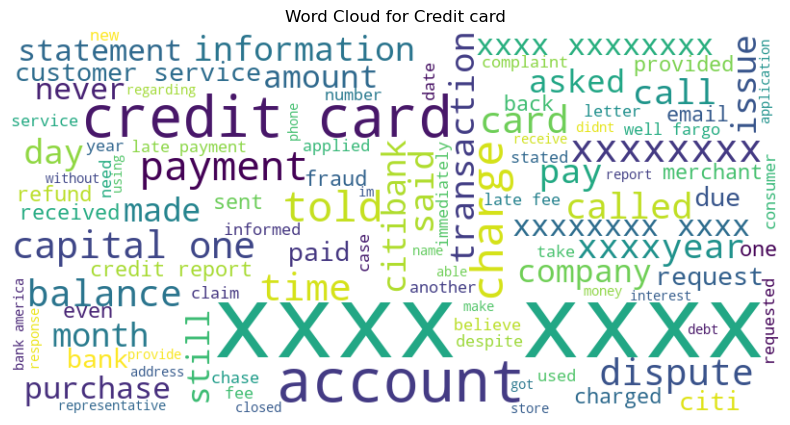

Showing common words...


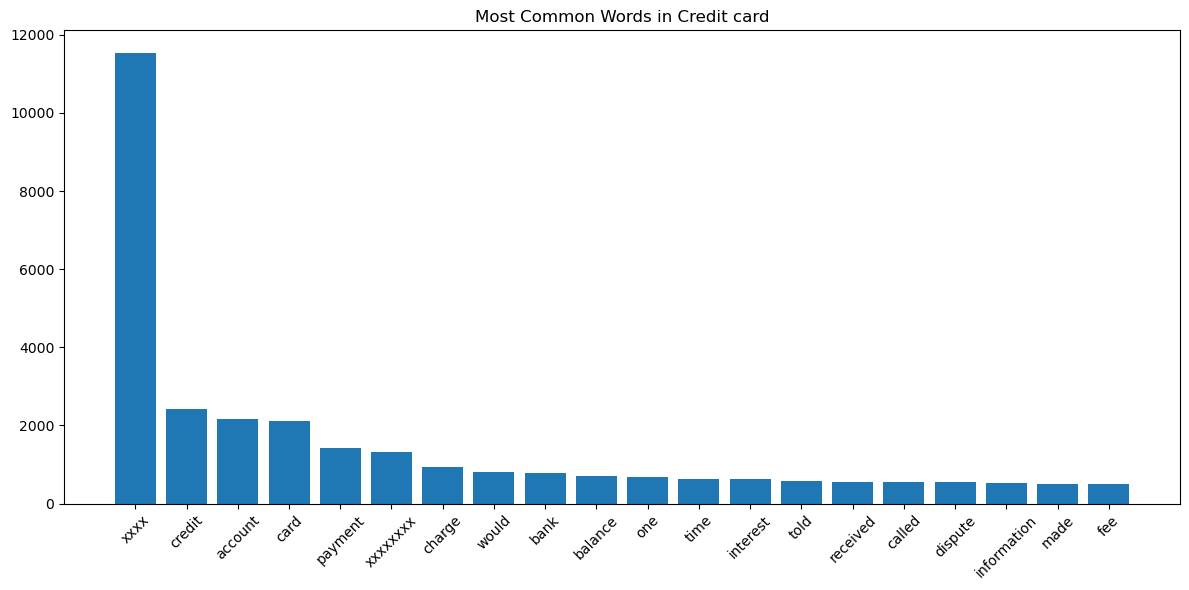


Processing Checking or savings account...
Creating word cloud...


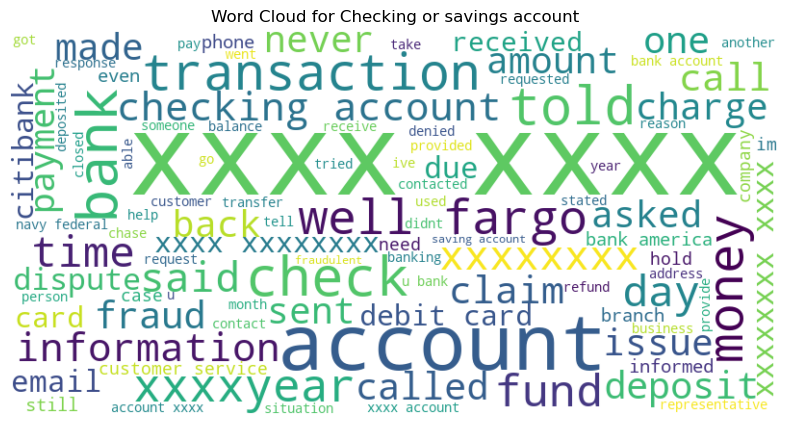

Showing common words...


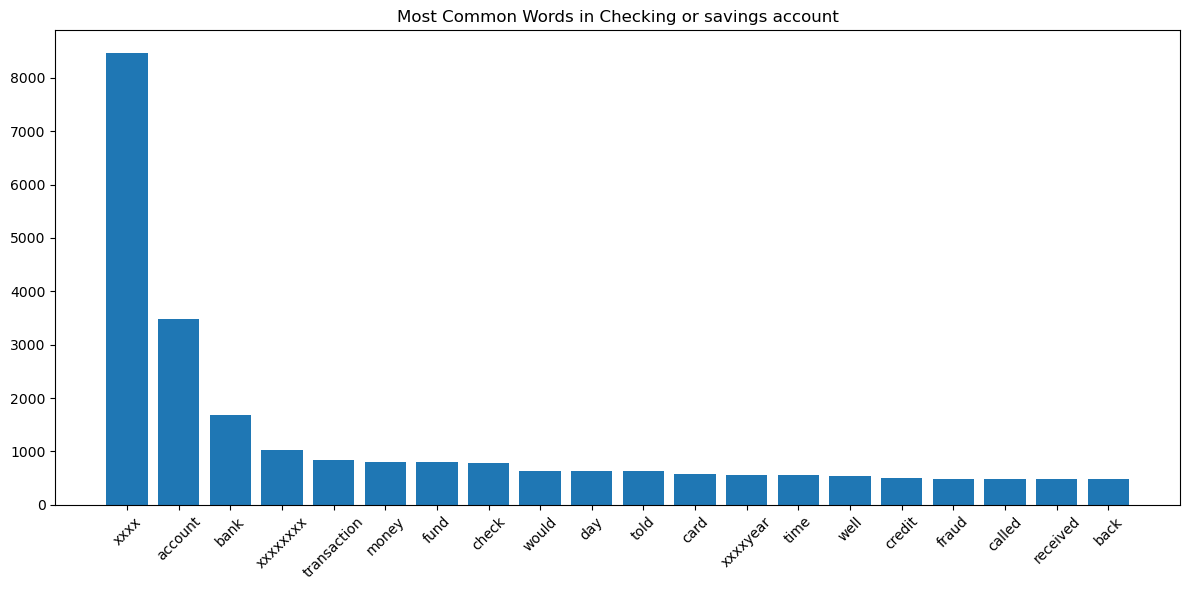


Processing Money transfer, virtual currency, or money service...
Creating word cloud...


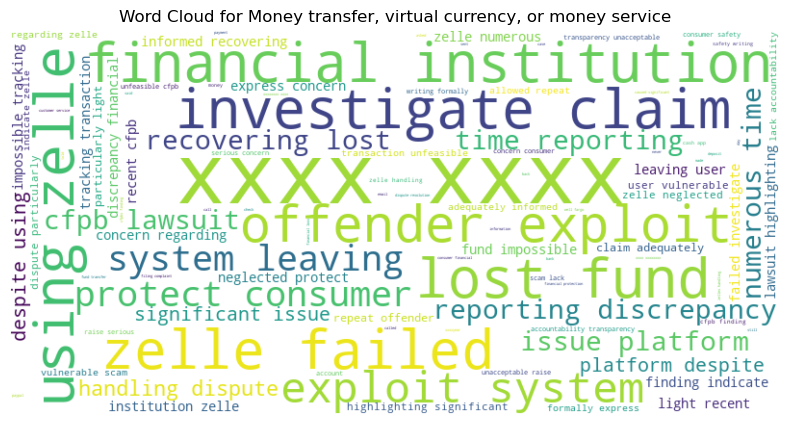

Showing common words...


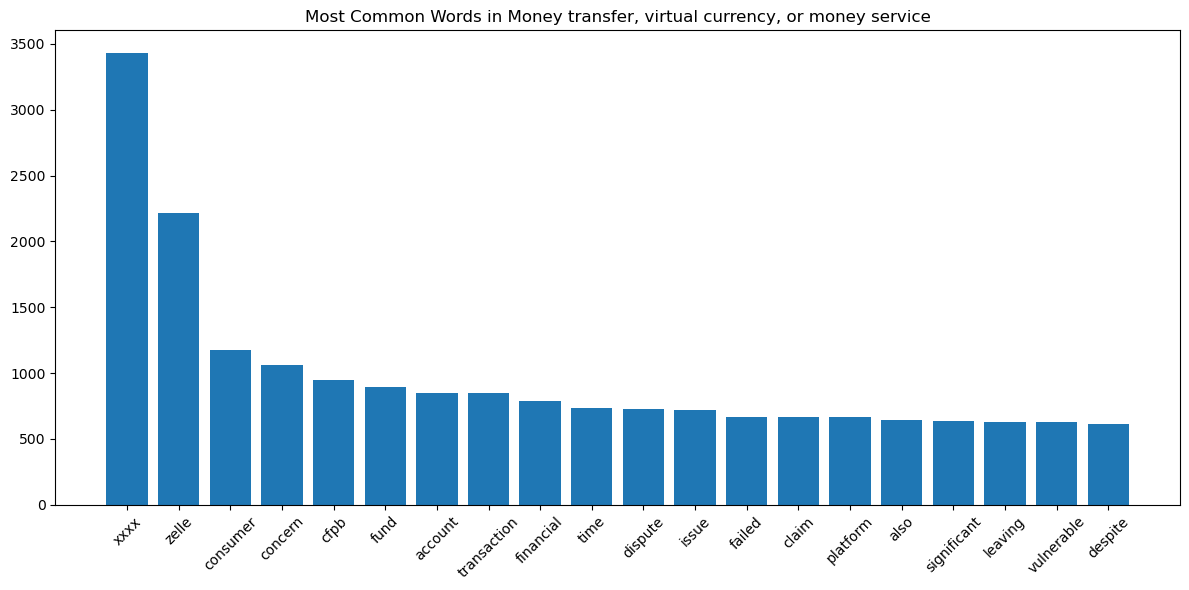


Processing Mortgage...
Creating word cloud...


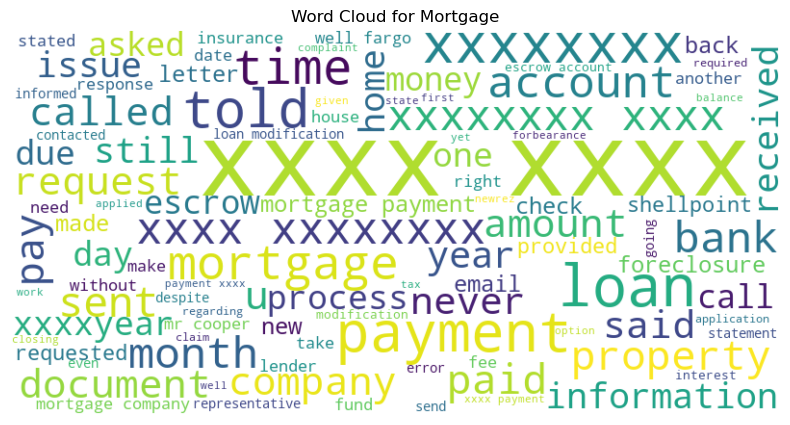

Showing common words...


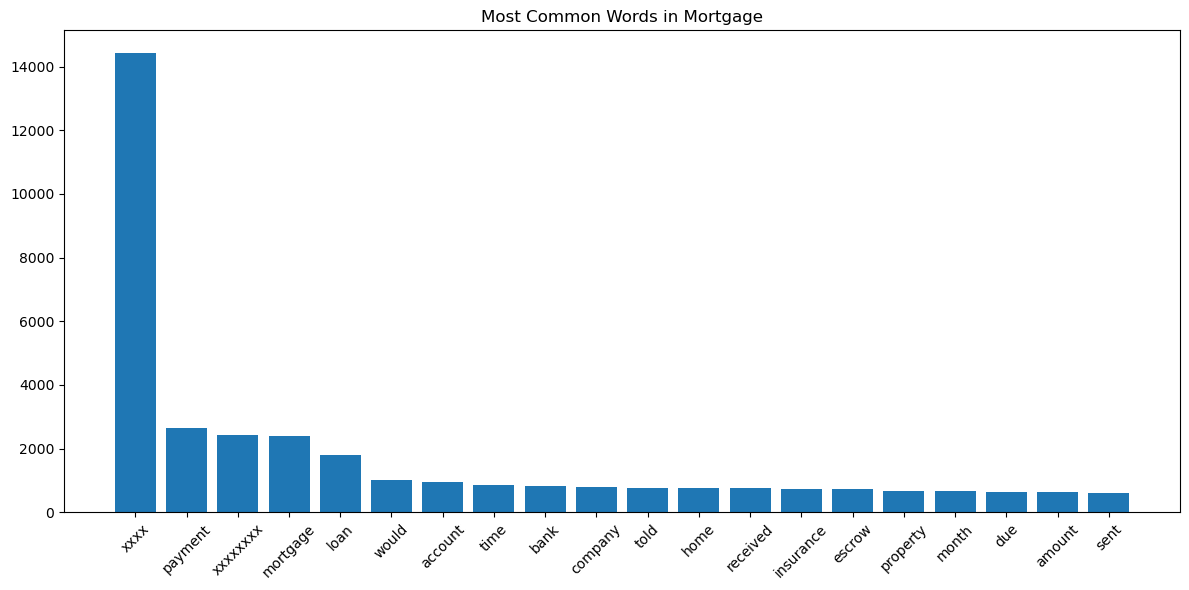


Processing Vehicle loan or lease...
Creating word cloud...


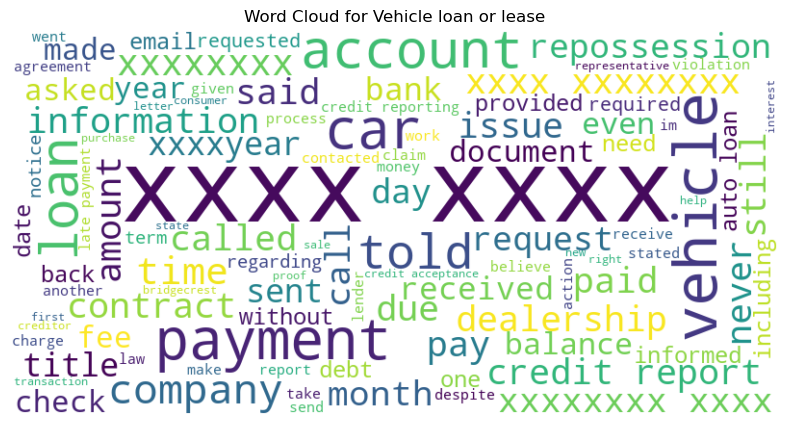

Showing common words...


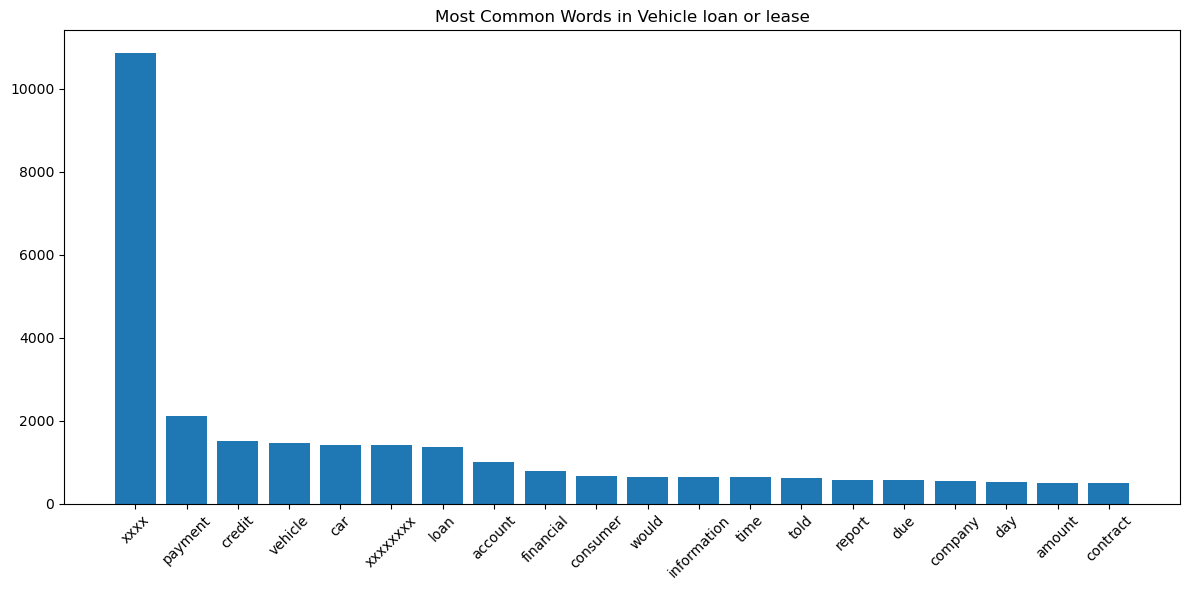


Processing Payday loan, title loan, personal loan, or advance loan...
Creating word cloud...


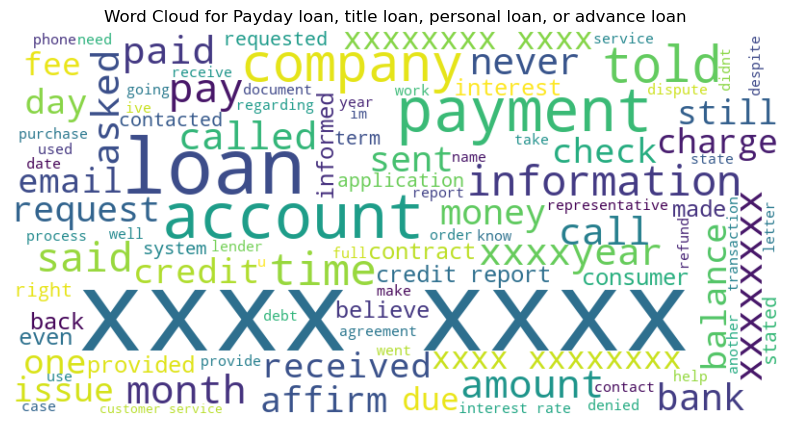

Showing common words...


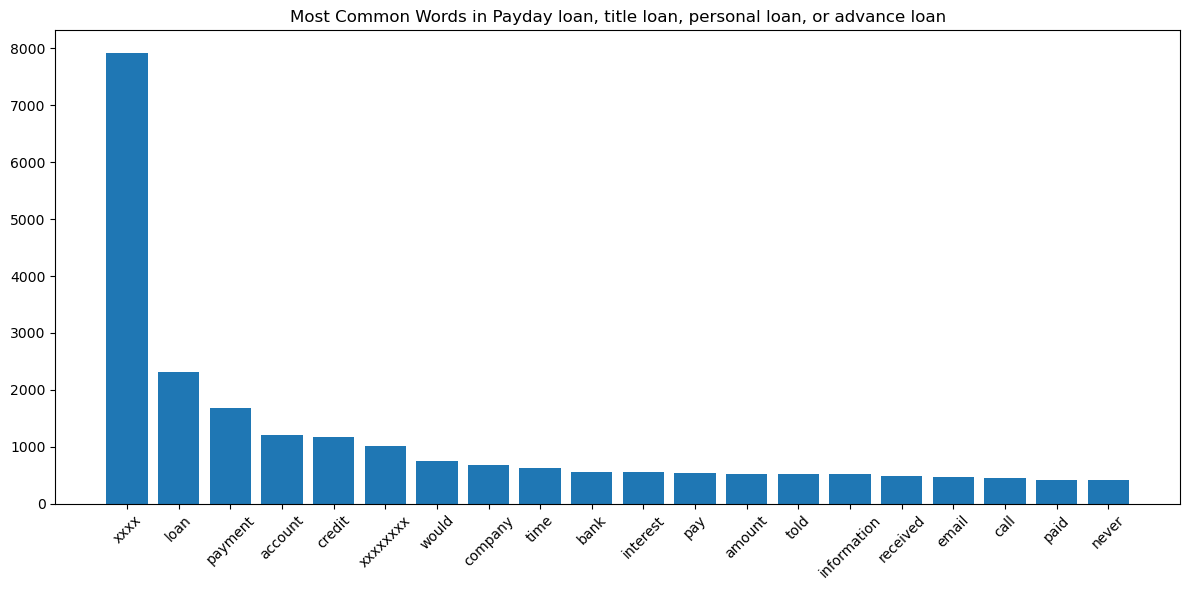


Processing Student loan...
Creating word cloud...


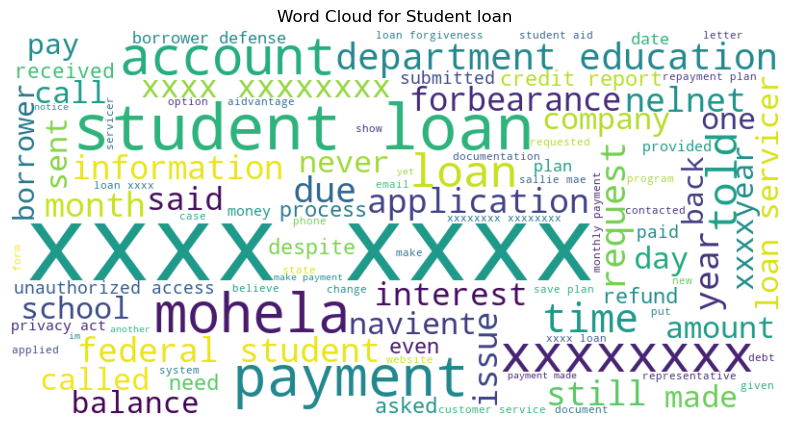

Showing common words...


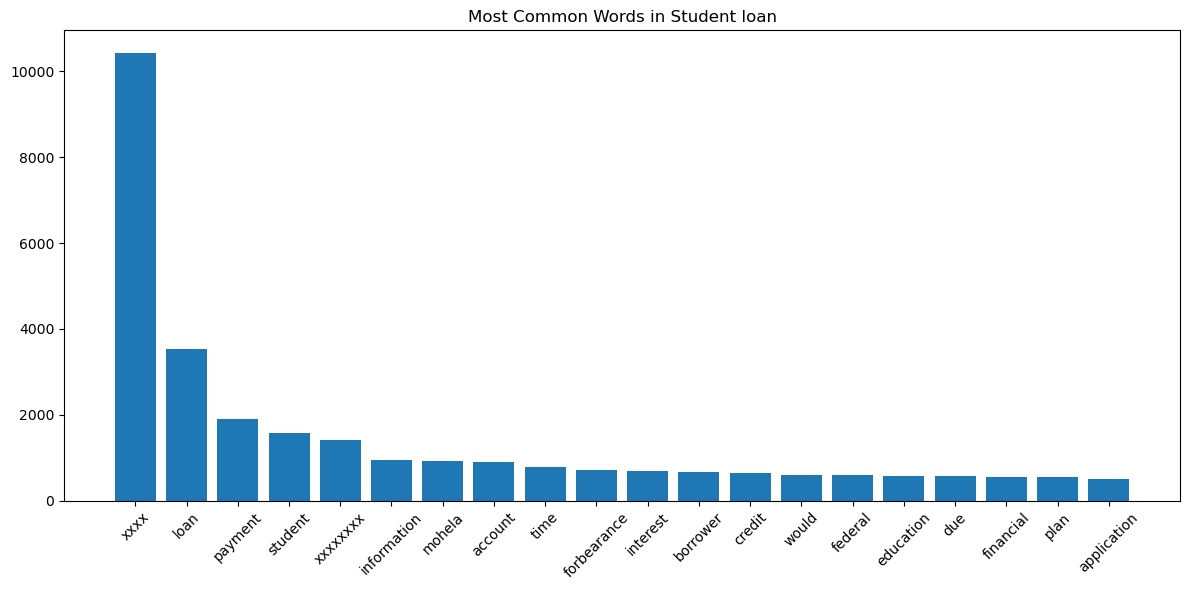


Processing Debt or credit management...
Creating word cloud...


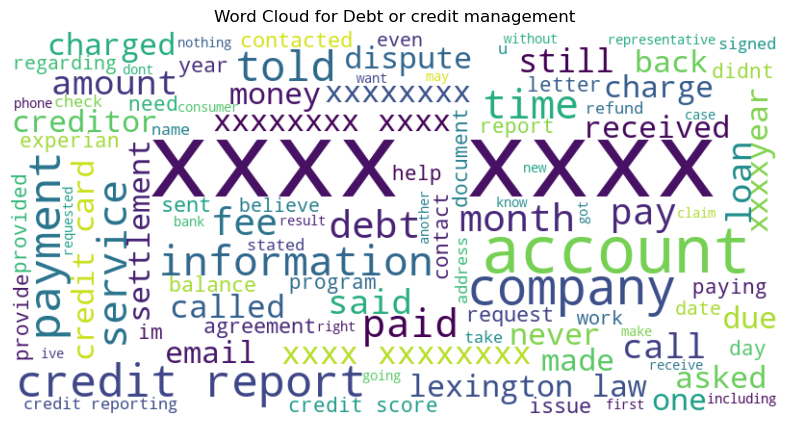

Showing common words...


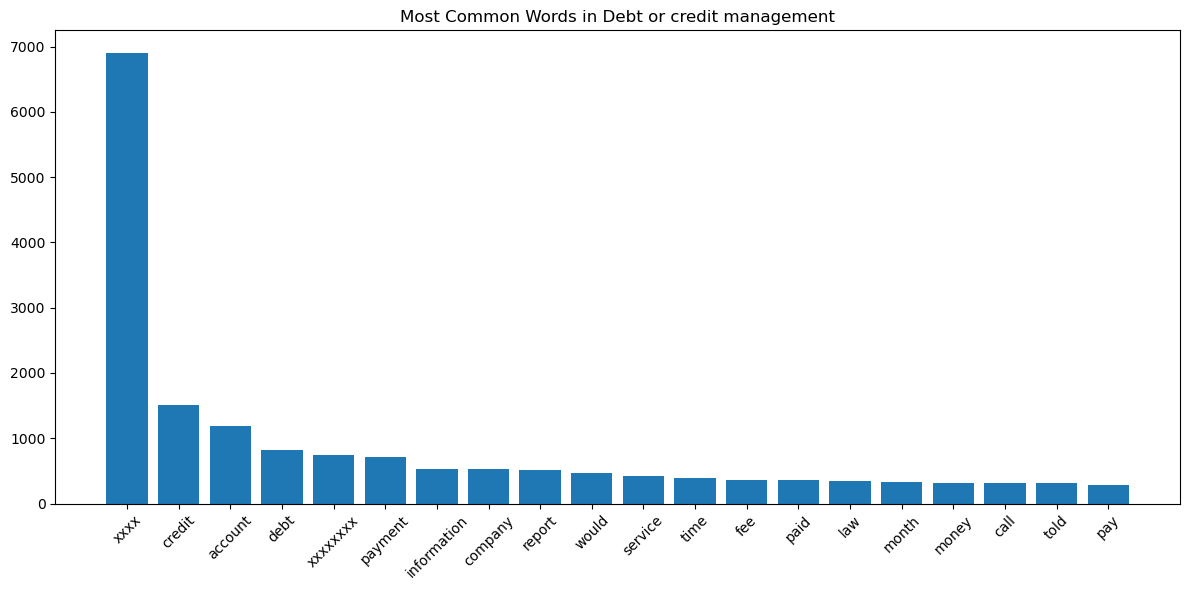


Processing Prepaid card...
Creating word cloud...


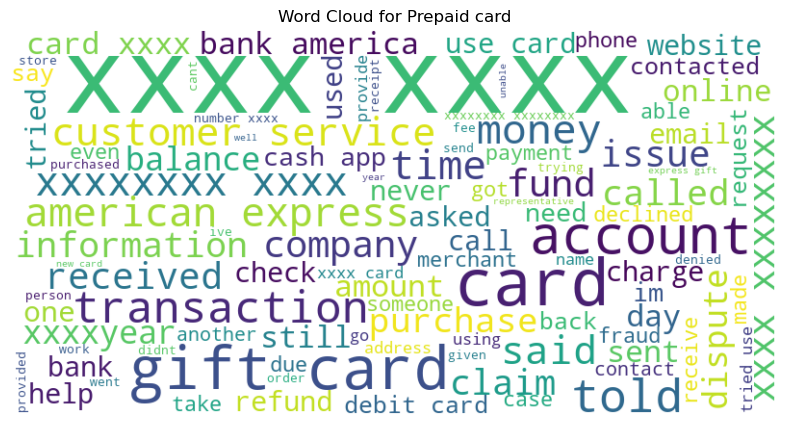

Showing common words...


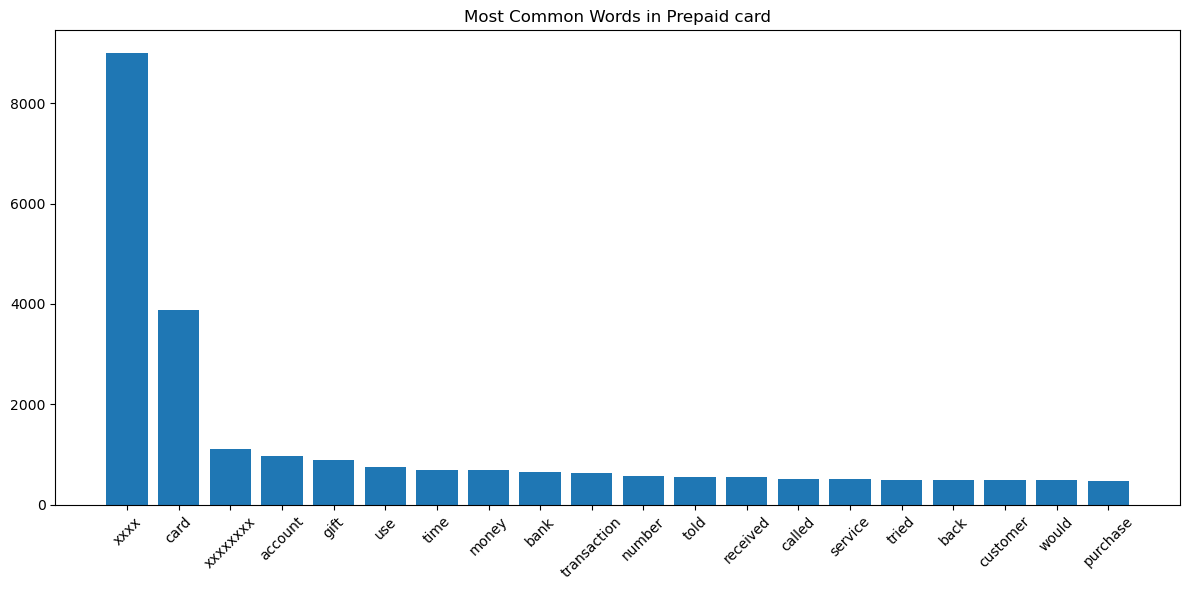


Processing Credit reporting...
Creating word cloud...


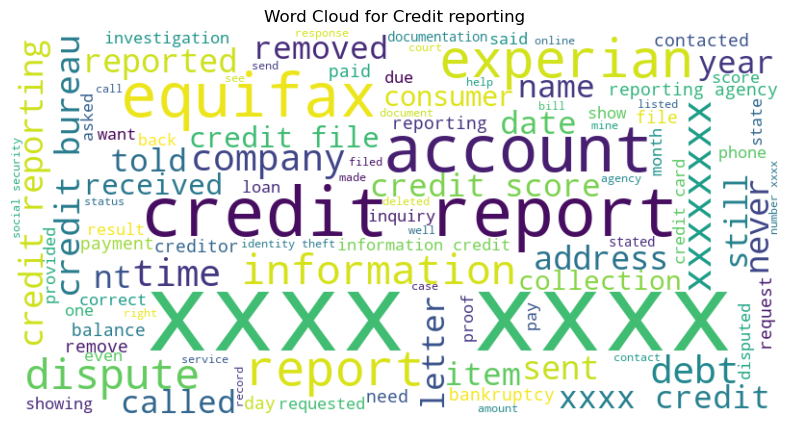

Showing common words...


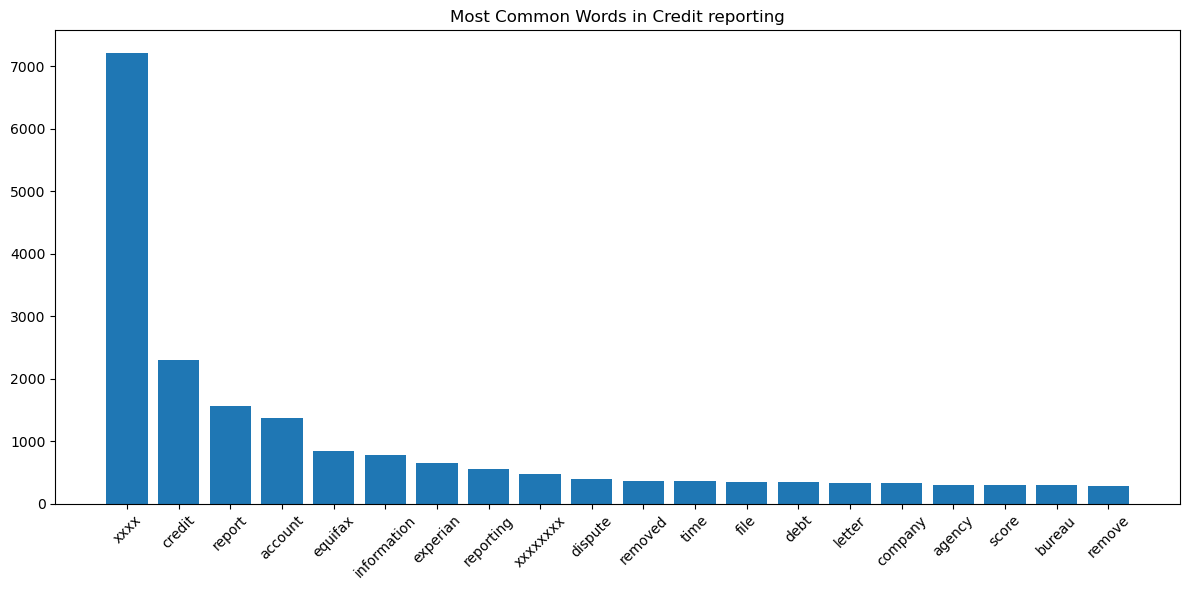


Processing Credit reporting, credit repair services, or other personal consumer reports...
Creating word cloud...


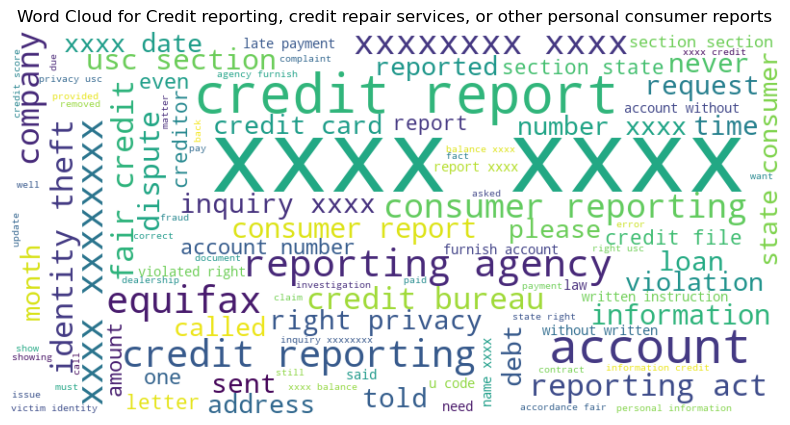

Showing common words...


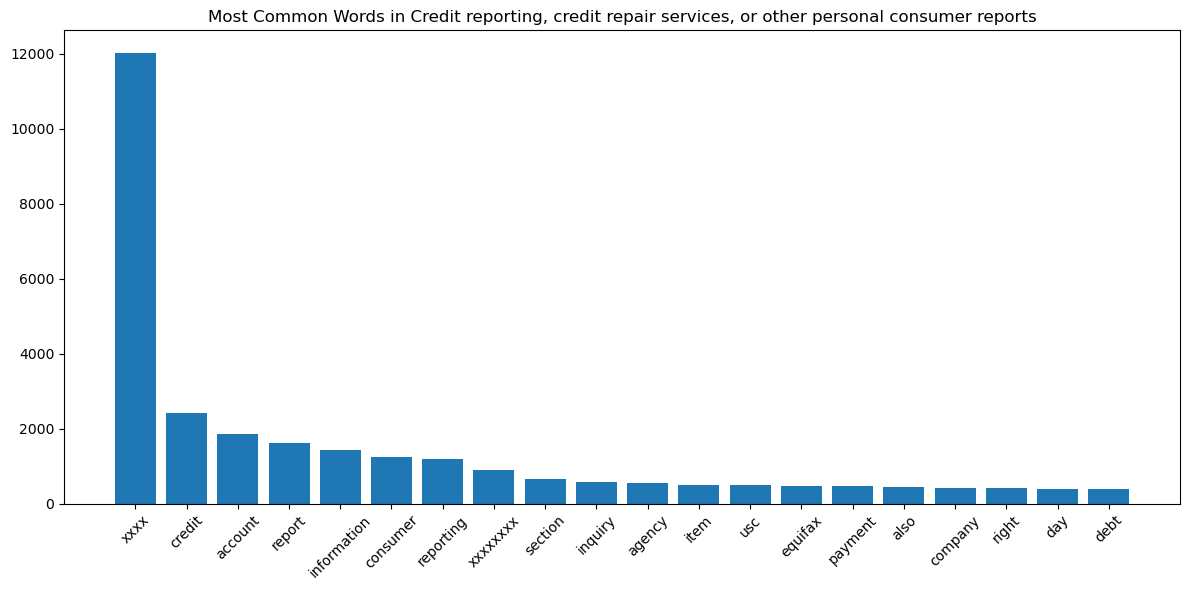


Processing Credit card or prepaid card...
Creating word cloud...


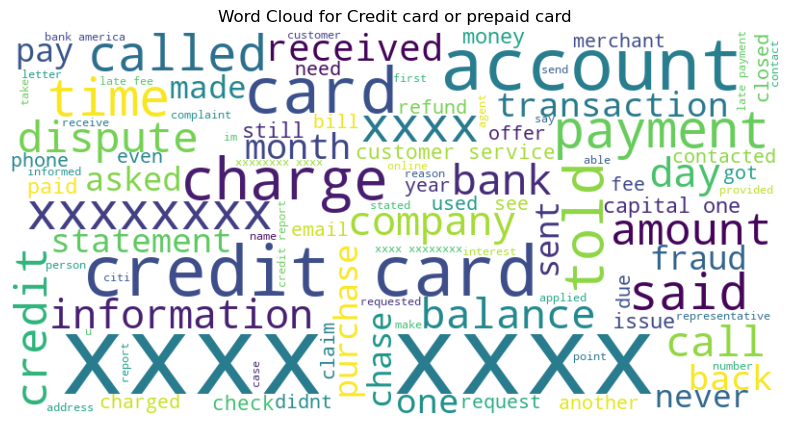

Showing common words...


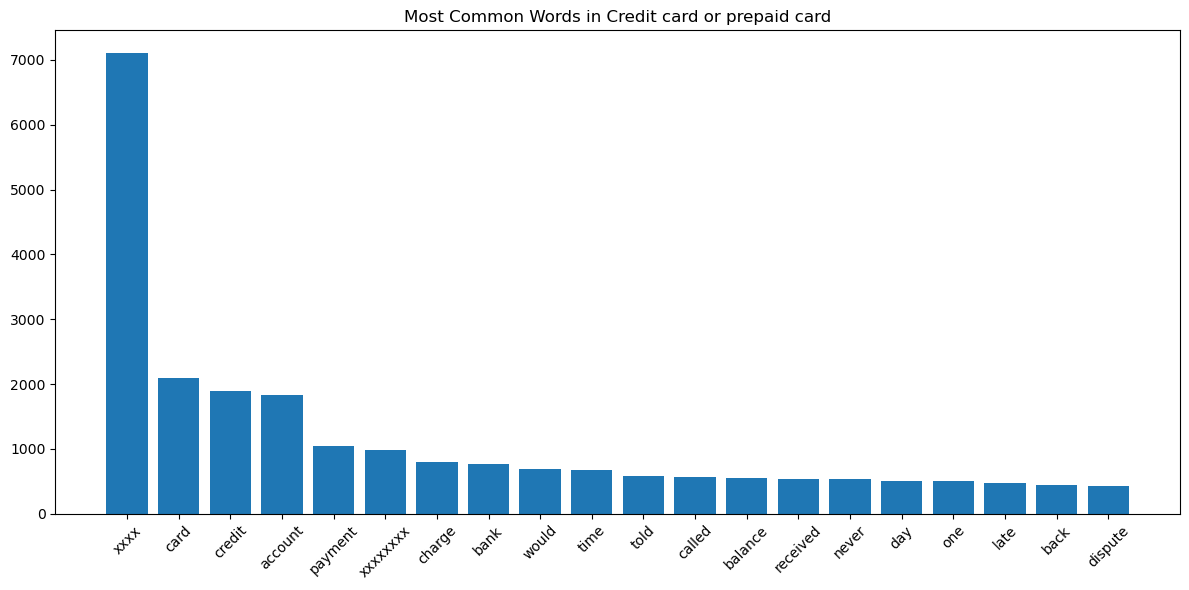


Processing Payday loan, title loan, or personal loan...
Creating word cloud...


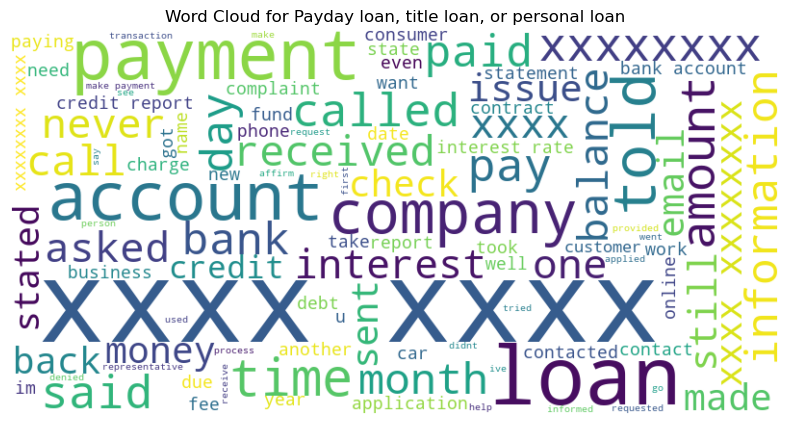

Showing common words...


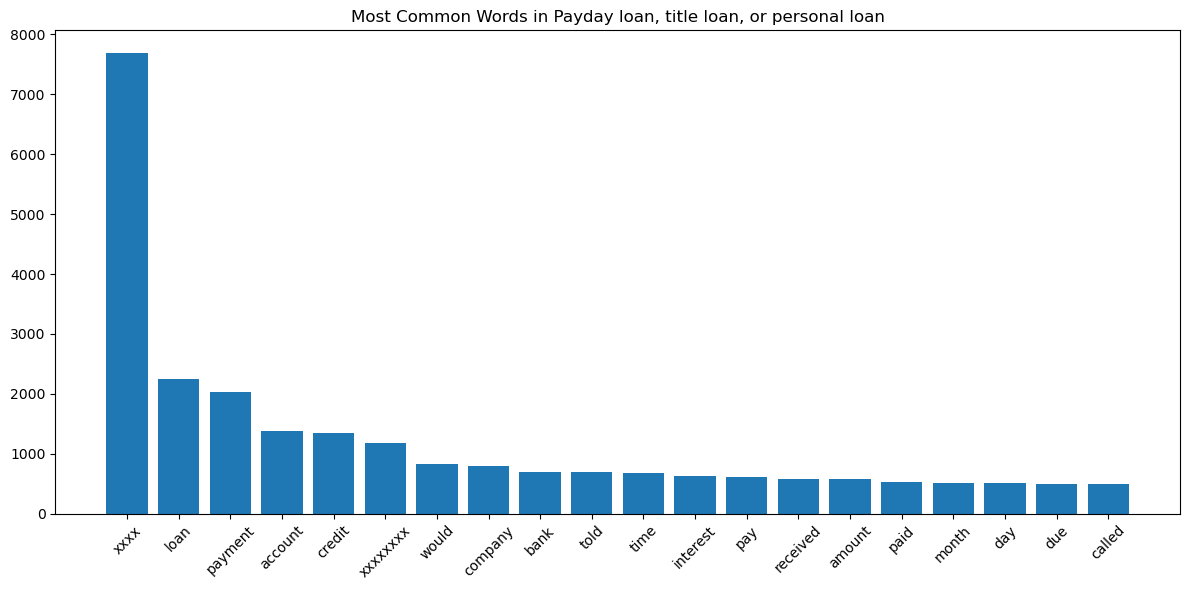


Processing Bank account or service...
Creating word cloud...


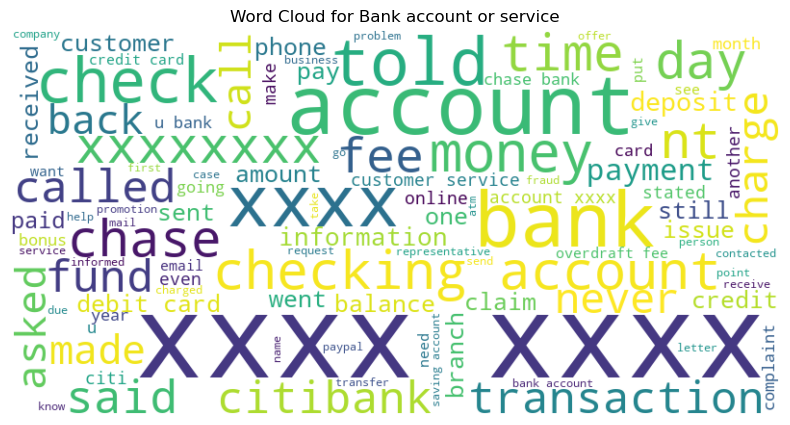

Showing common words...


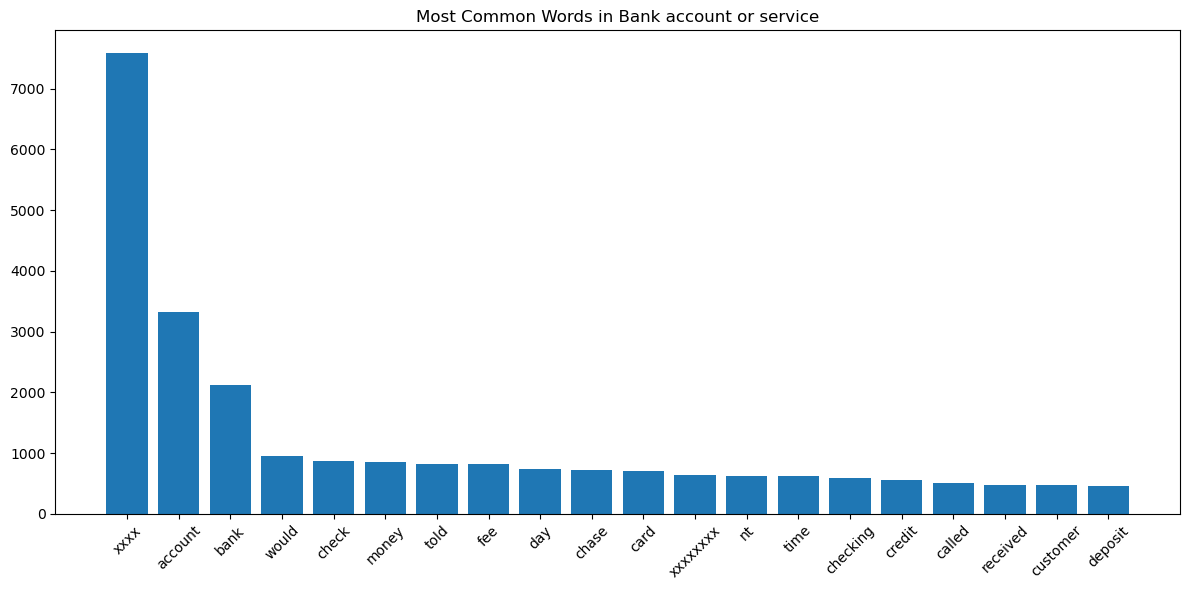


Processing Consumer Loan...
Creating word cloud...


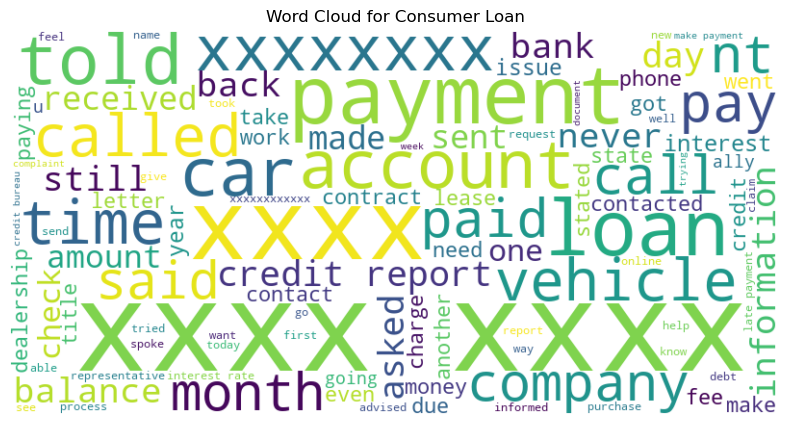

Showing common words...


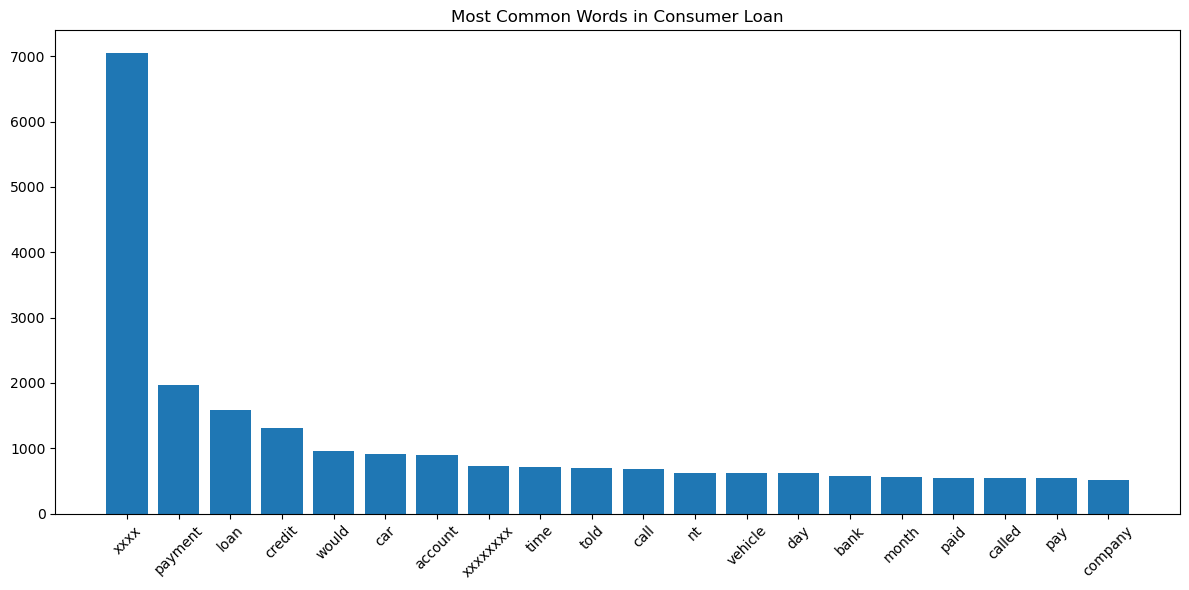


Processing Payday loan...
Creating word cloud...


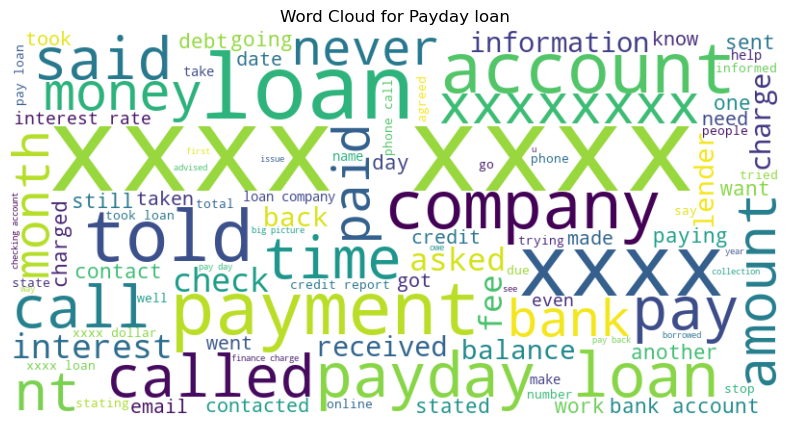

Showing common words...


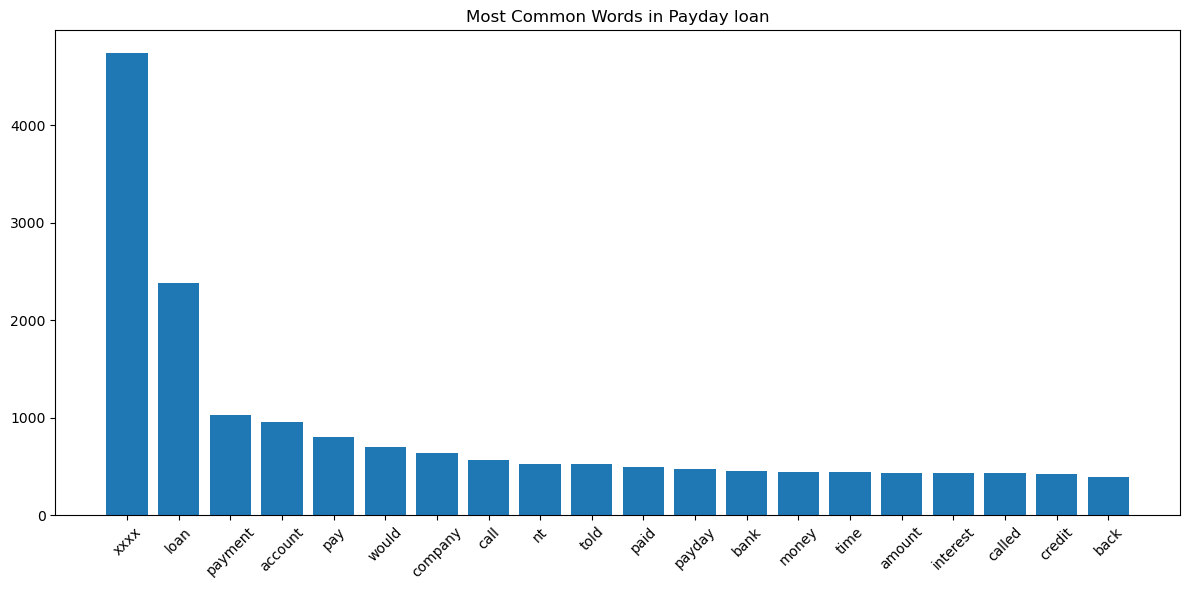


Processing Money transfers...
Creating word cloud...


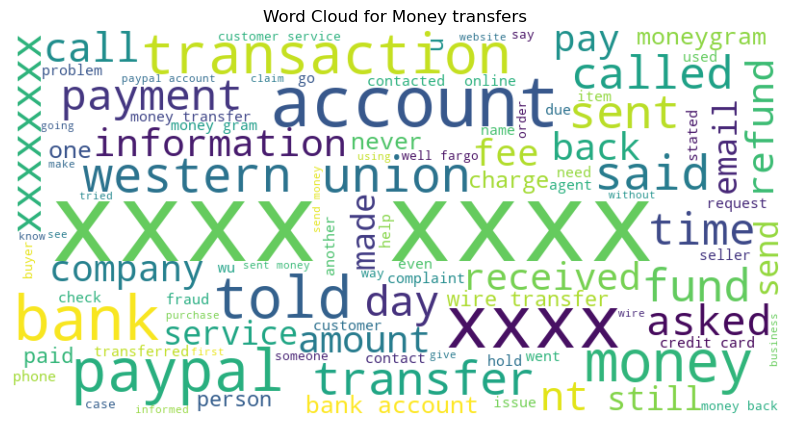

Showing common words...


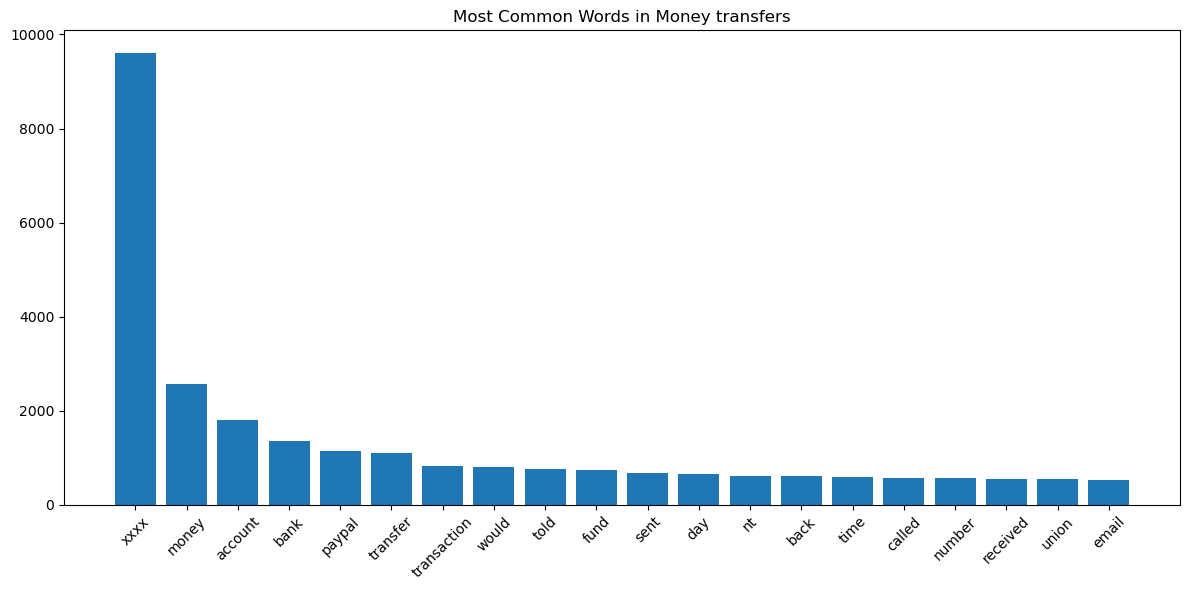


Processing Other financial service...
Creating word cloud...


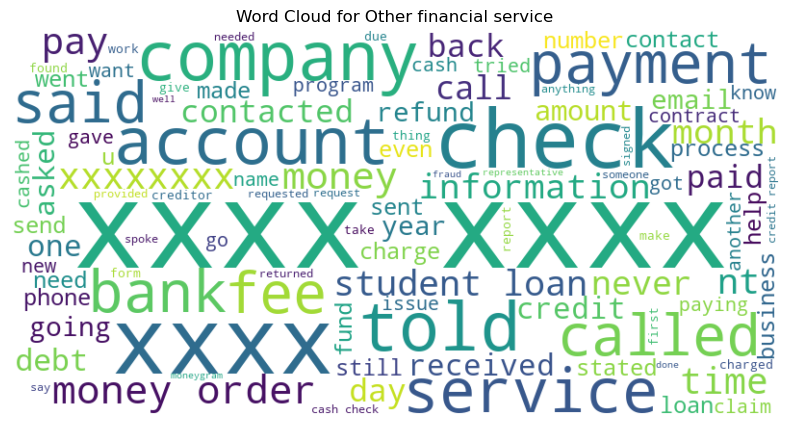

Showing common words...


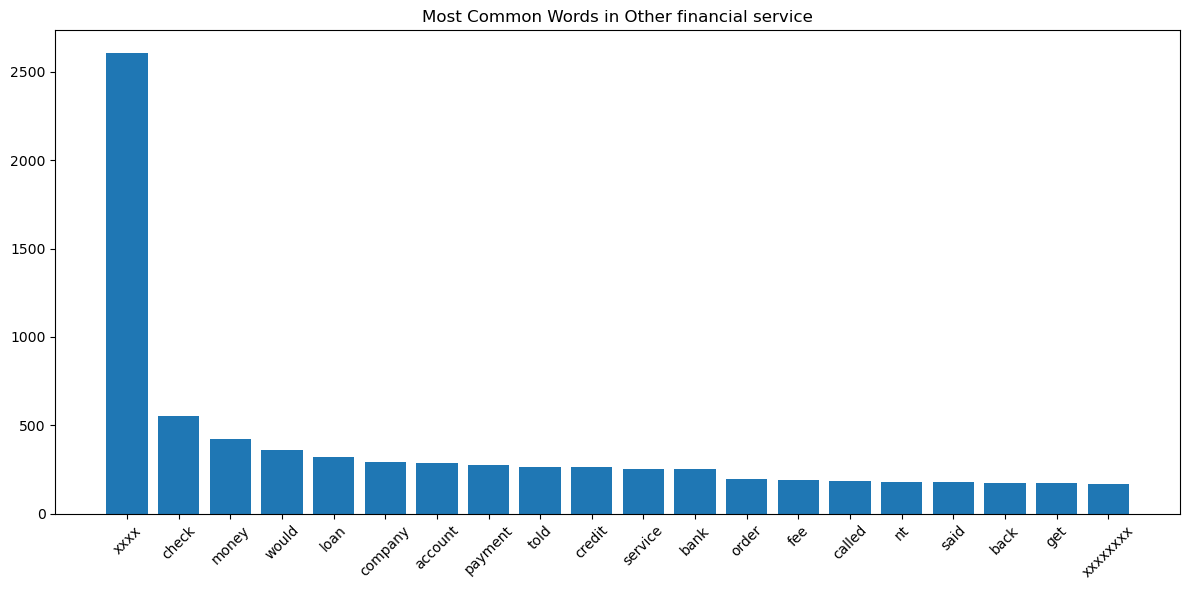


Processing Virtual currency...
Creating word cloud...


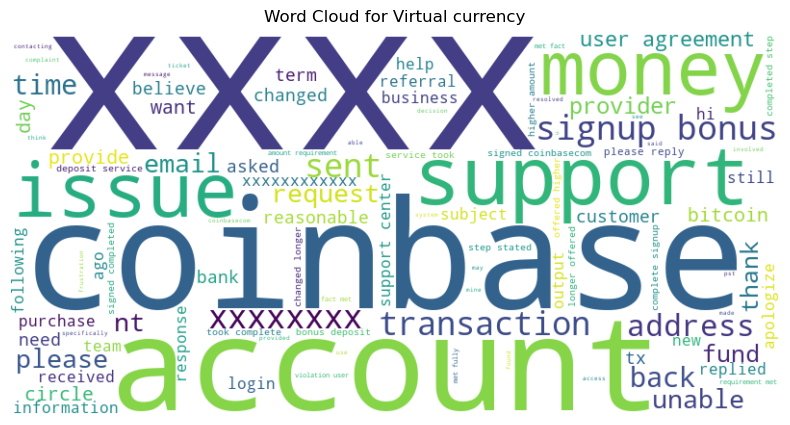

Showing common words...


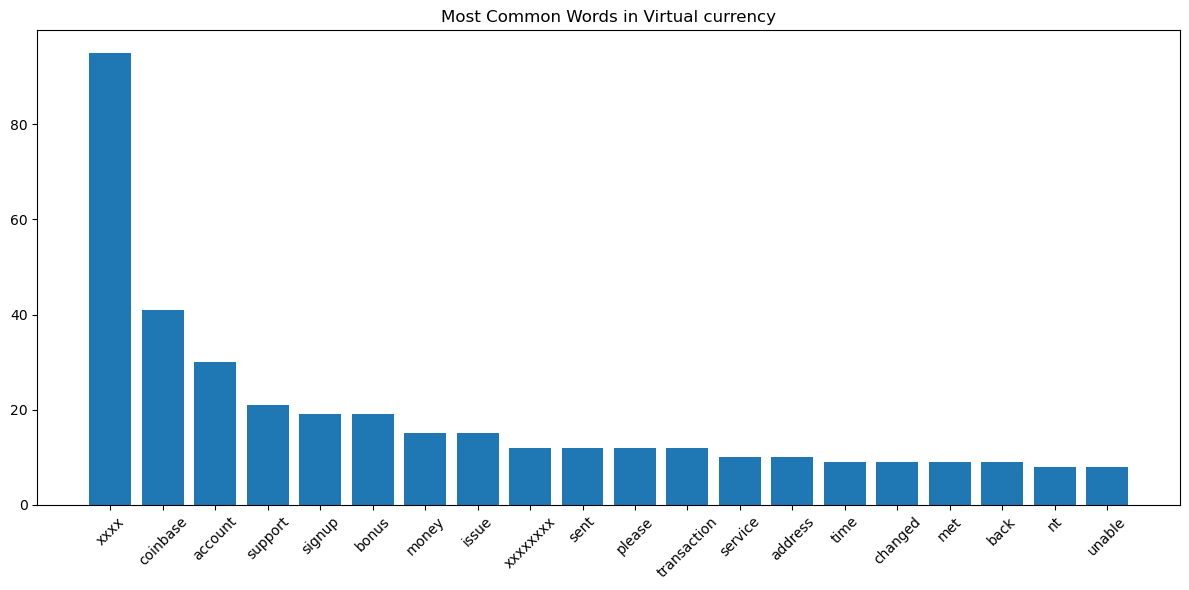


Analysis complete!


In [1]:
# Import stuff we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download all required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Read data in chunks to save memory
print("Reading data in chunks...")
chunk_size = 10000  # Adjust this based on your available memory
chunks = pd.read_csv('complaints.csv', chunksize=chunk_size)

# Initialize empty lists to store results
all_lengths = []
category_counts = {}

# Process each chunk
for chunk in chunks:
    # Count categories
    for category in chunk['Product'].value_counts().items():
        if category[0] in category_counts:
            category_counts[category[0]] += category[1]
        else:
            category_counts[category[0]] = category[1]
    
    # Get text lengths - handle non-string values
    lengths = []
    for text in chunk['Consumer complaint narrative'].dropna():
        if isinstance(text, str):
            lengths.append(len(text))
    all_lengths.extend(lengths)

# Convert category counts to DataFrame
category_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

# Basic info
print("\nWhat's in our dataset?")
print(f"Total complaints: {sum(category_counts.values())}")
print(f"Number of categories: {len(category_counts)}")

# Plot category distribution
plt.figure(figsize=(12, 6))
category_df.sort_values('Count', ascending=False).plot(kind='bar', x='Category', y='Count')
plt.title('Types of Complaints')
plt.xlabel('Category')
plt.ylabel('How Many')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot text length distribution
plt.figure(figsize=(10, 6))
plt.hist(all_lengths, bins=50)
plt.title('How Long are the Complaints?')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

print(f"Average length: {np.mean(all_lengths):.2f} characters")
print(f"Shortest: {min(all_lengths)} characters")
print(f"Longest: {max(all_lengths)} characters")

# Clean up the text - using simpler tokenization
def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # Make it lowercase
    text = text.lower()
    
    # Get rid of numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Split into words (simple split instead of word_tokenize)
    words = text.split()
    
    # Remove common words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    # Make words into their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    
    return ' '.join(words)

# Process each category separately
for category in category_counts.keys():
    print(f"\nProcessing {category}...")
    
    # Read only this category
    category_chunks = pd.read_csv('complaints.csv', 
                                chunksize=chunk_size,
                                usecols=['Product', 'Consumer complaint narrative'])
    
    # Collect texts for this category
    category_texts = []
    for chunk in category_chunks:
        # Filter for category and valid strings
        valid_texts = chunk[
            (chunk['Product'] == category) & 
            (chunk['Consumer complaint narrative'].notna())
        ]['Consumer complaint narrative']
        
        # Only keep string values
        category_texts.extend([text for text in valid_texts if isinstance(text, str)])
    
    # Take a sample if there are too many texts
    if len(category_texts) > 1000:
        category_texts = category_texts[:1000]
    
    if not category_texts:  # Skip if no valid texts
        print(f"No valid texts found for {category}")
        continue
    
    # Clean and combine texts
    clean_texts = ' '.join([clean_text(text) for text in category_texts])
    
    # Show word cloud
    print("Creating word cloud...")
    cloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     max_words=100).generate(clean_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()
    
    # Count words
    words = clean_texts.split()
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    
    # Get top 20 words
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
    
    # Show common words
    print("Showing common words...")
    words, counts = zip(*top_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.title(f'Most Common Words in {category}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nAnalysis complete!")

In [5]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add custom stopwords
custom_stopwords = {
    'would', 'could', 'should', 'also', 'get', 'got', 'getting',
    'said', 'say', 'says', 'saying', 'told', 'tell', 'telling',
    'called', 'call', 'calling', 'contacted', 'contact', 'contacting',
    'received', 'receive', 'receiving', 'sent', 'send', 'sending',
    'tried', 'try', 'trying', 'attempted', 'attempt', 'attempting',
    'asked', 'ask', 'asking', 'requested', 'request', 'requesting',
    'thank', 'thanks', 'thanked', 'thank you', 'please', 'kindly',
    'regards', 'sincerely', 'best', 'best regards', 'yours',
    'dear', 'hello', 'hi', 'greetings', 'good', 'morning', 'afternoon',
    'evening', 'night', 'day', 'week', 'month', 'year', 'date',
    'time', 'today', 'yesterday', 'tomorrow', 'now', 'then', 'when',
    'where', 'what', 'which', 'who', 'whom', 'whose', 'why', 'how'
}
stop_words.update(custom_stopwords)

def preprocess_text(text):
    """Main preprocessing function"""
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Split into words and process
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    return ' '.join(words)

# Check working directory and file
print("\nCurrent working directory:", os.getcwd())
print("Does 'complaints.csv' exist?", os.path.exists('complaints.csv'))

# Read the data
print("\nReading data...")
df = pd.read_csv('complaints.csv')

# Show basic information
print("\nDataset Info:")
print(f"Total rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

# Check for non-null values
non_null_count = df['Consumer complaint narrative'].notna().sum()
print(f"\nNumber of non-null complaint narratives: {non_null_count}")
print(f"Percentage of non-null values: {(non_null_count/len(df))*100:.2f}%")

# Filter out rows with null narratives
df = df.dropna(subset=['Consumer complaint narrative'])

# Take a sample of non-null values
sample_size = min(1000, len(df))
print(f"\nTaking sample of {sample_size} non-null complaints...")
df_sample = df.sample(n=sample_size, random_state=42)

# Preprocess the sample
print("\nProcessing sample data...")
df_sample['processed_text'] = df_sample['Consumer complaint narrative'].apply(preprocess_text)

# Show examples
print("\nExample of original and processed text:")
for i in range(3):
    original = df_sample['Consumer complaint narrative'].iloc[i]
    processed = df_sample['processed_text'].iloc[i]
    print("\nOriginal:", str(original)[:100], "...")
    print("Processed:", processed[:100], "...")

# Show some statistics
print("\nProcessing complete!")
print(f"Number of complaints processed: {len(df_sample)}")

# Show text length statistics
df_sample['processed_length'] = df_sample['processed_text'].str.len()
print("\nProcessed text length statistics:")
print(df_sample['processed_length'].describe())

# Show sample of processed data
print("\nSample of processed data:")
print(df_sample[['Product', 'Consumer complaint narrative', 'processed_text']].head())

# Save the processed sample
print("\nSaving processed sample to 'processed_complaints_sample.csv'...")
df_sample.to_csv('processed_complaints_sample.csv', index=False)
print("File saved successfully!")


Current working directory: C:\Users\user\Desktop\task_5
Does 'complaints.csv' exist? True

Reading data...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\user\AppData\Local\Temp\ipykernel_19588\2568653557.py:59: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')



Dataset Info:
Total rows: 9404047
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

Number of non-null complaint narratives: 2930307
Percentage of non-null values: 31.16%

Taking sample of 1000 non-null complaints...

Processing sample data...

Example of original and processed text:

Original: My credit profile is showing that I have an open account and balance with XXXX. XXXX is no longer my ...
Processed: credit profile showing open account balance xxxx xxxx longer student loan provider xxxx account clos ...

Original: On XX/XX/XXXX, a fraudulent check was cashed on my checking account with SunTrust Bank. I called the ...
Processed: xx xx xxxx fraudulent check cashed checking account suntrust bank fra

Loading data from original file...

Handling NaN values...

Top 4 categories in our data:
['Credit reporting or other personal consumer reports', 'Debt collection', 'Credit card', 'Checking or savings account']

Number of samples after cleaning: 294

Categories in cleaned data:
Product
Credit reporting or other personal consumer reports    248
Debt collection                                         25
Credit card                                             14
Checking or savings account                              7
Name: count, dtype: int64

Preparing data for classification...
Creating TF-IDF features...

Training and evaluating models...

Training Multinomial Naive Bayes...

Multinomial Naive Bayes Results:
Accuracy: 0.8475

Classification Report:
                                                     precision    recall  f1-score   support

                        Checking or savings account       0.00      0.00      0.00         1
                                        Credit card

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


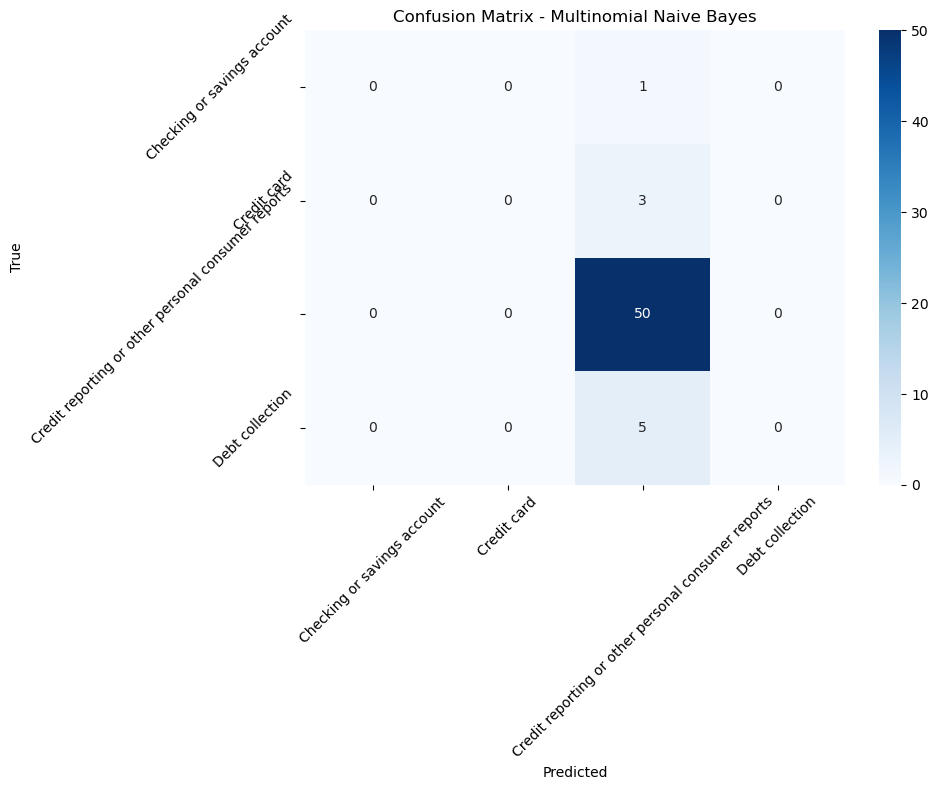


Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8305

Classification Report:
                                                     precision    recall  f1-score   support

                        Checking or savings account       0.00      0.00      0.00         1
                                        Credit card       0.33      0.33      0.33         3
Credit reporting or other personal consumer reports       0.92      0.92      0.92        50
                                    Debt collection       0.40      0.40      0.40         5

                                           accuracy                           0.83        59
                                          macro avg       0.41      0.41      0.41        59
                                       weighted avg       0.83      0.83      0.83        59



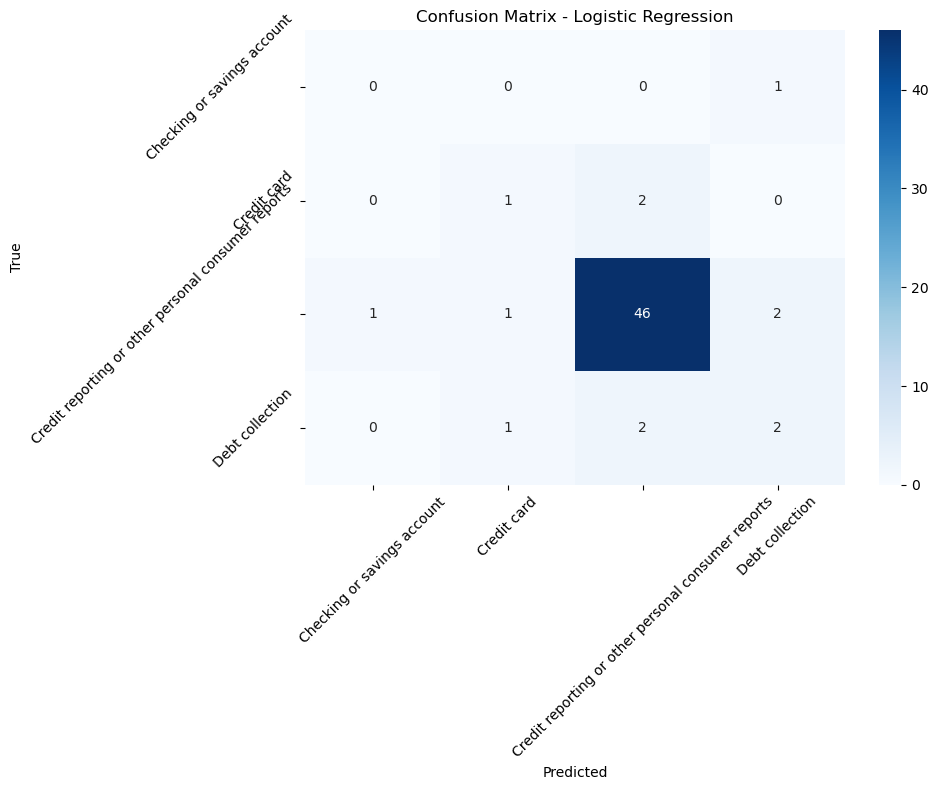


Training Linear SVM...

Linear SVM Results:
Accuracy: 0.8475

Classification Report:
                                                     precision    recall  f1-score   support

                        Checking or savings account       0.00      0.00      0.00         1
                                        Credit card       0.00      0.00      0.00         3
Credit reporting or other personal consumer reports       0.86      0.98      0.92        50
                                    Debt collection       1.00      0.20      0.33         5

                                           accuracy                           0.85        59
                                          macro avg       0.46      0.29      0.31        59
                                       weighted avg       0.81      0.85      0.80        59



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


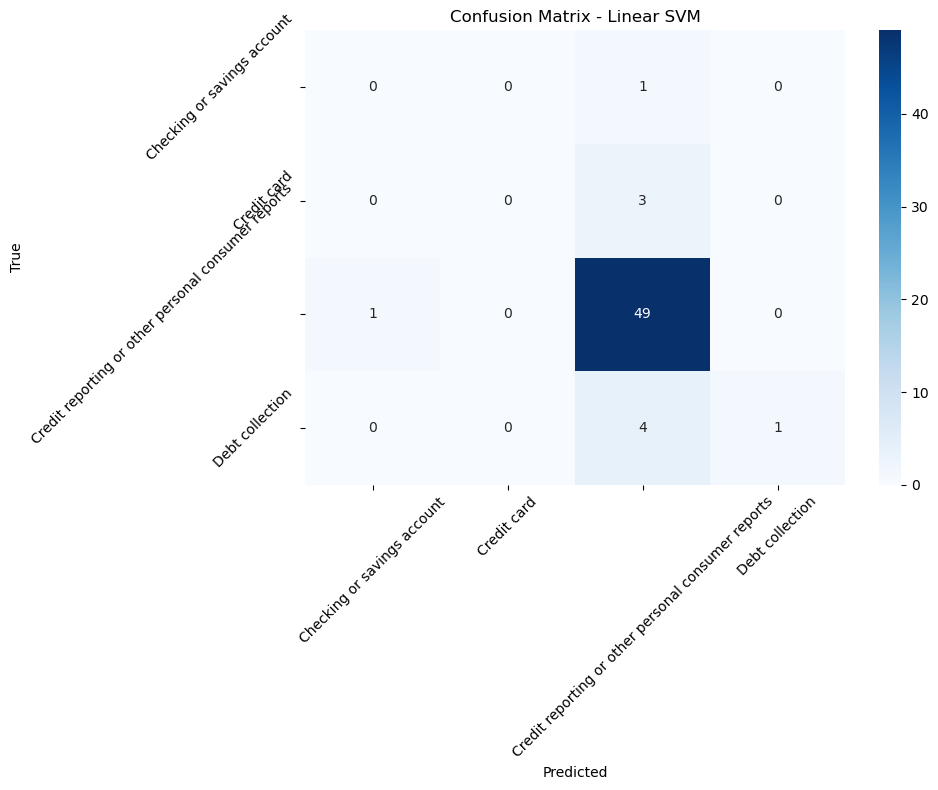


Model Comparison:


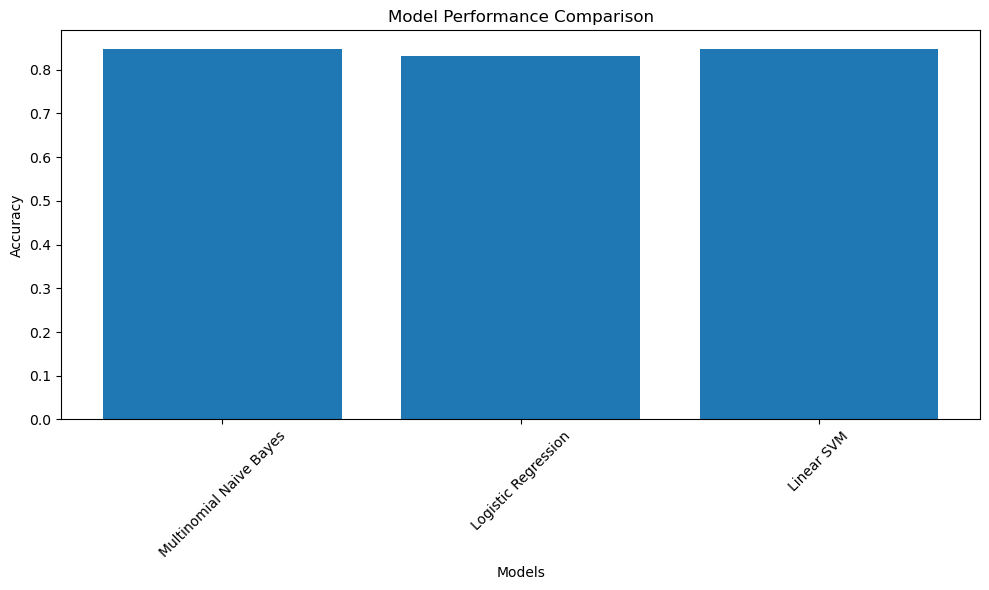


Best performing model: Multinomial Naive Bayes

Models and vectorizers saved successfully!

Testing prediction with a sample complaint...
Sample complaint: I have been receiving calls from a debt collector about a credit card debt
Predicted category: Credit reporting or other personal consumer reports


In [25]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load more data from the original file
print("Loading data from original file...")
# Read 20000 rows from the original file
df = pd.read_csv('complaints.csv', nrows=20000)

# Keep only the columns we need
df = df[['Product', 'Consumer complaint narrative']]

# Rename columns for clarity
df.columns = ['Product', 'processed_text']

# Handle NaN values in text
print("\nHandling NaN values...")
df['processed_text'] = df['processed_text'].fillna('')  # Replace NaN with empty string

# Get the top 4 most common categories
print("\nTop 4 categories in our data:")
top_categories = df['Product'].value_counts().nlargest(4).index.tolist()
print(top_categories)

# Filter data to only include top 4 categories
df = df[df['Product'].isin(top_categories)]

# Remove rows with empty text
df = df[df['processed_text'].str.strip() != '']

print(f"\nNumber of samples after cleaning: {len(df)}")
print("\nCategories in cleaned data:")
print(df['Product'].value_counts())

# Prepare the data
print("\nPreparing data for classification...")
# Convert categories to numerical labels
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['Product'])

# Create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=3000,    # Keep it simple
    ngram_range=(1, 2),   # Use word pairs
    min_df=5,             # Ignore rare words
    max_df=0.8           # Ignore common words
)
X = tfidf.fit_transform(df['processed_text'])
y = df['category']

# Split the data using stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models with basic parameters
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Linear SVM': LinearSVC(max_iter=1000, class_weight='balanced')
}

# Train and evaluate models
print("\nTraining and evaluating models...")
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    # Get unique classes in test set
    unique_classes = np.unique(y_test)
    class_names = label_encoder.inverse_transform(unique_classes)
    
    # Print detailed metrics
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                              target_names=class_names))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compare model performances
print("\nModel Comparison:")
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the best model
best_model_name = max(results.items(), key=lambda x: x[1])[0]
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

# Save the model and vectorizer
import joblib
joblib.dump(best_model, 'best_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')
print("\nModels and vectorizers saved successfully!")

# Example prediction function
def predict_complaint(text, model, vectorizer, label_encoder):
    # Transform the text
    features = vectorizer.transform([text])
    # Make prediction
    prediction = model.predict(features)
    # Convert prediction back to original label
    return label_encoder.inverse_transform(prediction)[0]

# Test the prediction
print("\nTesting prediction with a sample complaint...")
sample_text = "I have been receiving calls from a debt collector about a credit card debt"
prediction = predict_complaint(sample_text, best_model, tfidf, label_encoder)
print(f"Sample complaint: {sample_text}")
print(f"Predicted category: {prediction}")

Loading saved model and data...
Loading test data...

Making predictions on test data...

Overall Accuracy: 0.8435

Detailed Classification Report:
                                                     precision    recall  f1-score   support

                        Checking or savings account       0.00      0.00      0.00         7
                                        Credit card       0.00      0.00      0.00        14
Credit reporting or other personal consumer reports       0.84      1.00      0.92       248
                                    Debt collection       0.00      0.00      0.00        25

                                           accuracy                           0.84       294
                                          macro avg       0.21      0.25      0.23       294
                                       weighted avg       0.71      0.84      0.77       294


Creating confusion matrix...


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


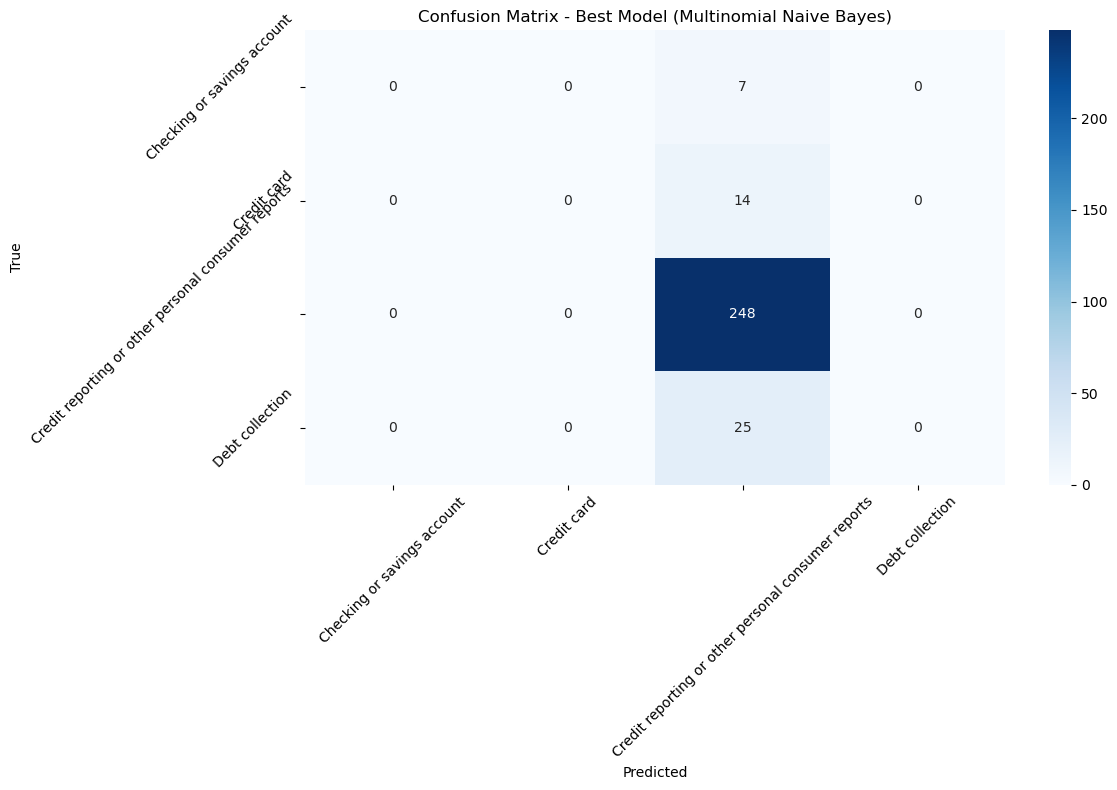


Category-wise Performance:

Checking or savings account:
Total samples: 7
Correctly predicted: 0
Precision: 0.0000
Recall: 0.0000

Credit card:
Total samples: 14
Correctly predicted: 0
Precision: 0.0000
Recall: 0.0000

Credit reporting or other personal consumer reports:
Total samples: 248
Correctly predicted: 248
Precision: 0.8435
Recall: 1.0000

Debt collection:
Total samples: 25
Correctly predicted: 0
Precision: 0.0000
Recall: 0.0000

Testing with example complaints...

Complaint: I have been receiving calls from a debt collector about a credit card debt
Predicted category: Credit reporting or other personal consumer reports

Complaint: My credit report shows incorrect information that needs to be fixed
Predicted category: Credit reporting or other personal consumer reports

Complaint: I'm having issues with my checking account transactions
Predicted category: Credit reporting or other personal consumer reports

Complaint: My credit card company charged me incorrect fees
Predicted 

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the saved model and data
print("Loading saved model and data...")
best_model = joblib.load('best_model.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')
label_encoder = joblib.load('label_encoder.joblib')

# Load test data
print("Loading test data...")
df = pd.read_csv('complaints.csv', nrows=20000)
df = df[['Product', 'Consumer complaint narrative']]
df.columns = ['Product', 'processed_text']

# Handle NaN values
df['processed_text'] = df['processed_text'].fillna('')
df = df[df['processed_text'].str.strip() != '']

# Get top categories
top_categories = df['Product'].value_counts().nlargest(4).index.tolist()
df = df[df['Product'].isin(top_categories)]

# Prepare test data
X_test = tfidf.transform(df['processed_text'])
y_test = label_encoder.transform(df['Product'])

# Make predictions
print("\nMaking predictions on test data...")
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_))

# Create confusion matrix
print("\nCreating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Best Model (Multinomial Naive Bayes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print category-wise performance
print("\nCategory-wise Performance:")
for i, category in enumerate(label_encoder.classes_):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    total = sum(cm[i, :])
    
    # Handle division by zero
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    print(f"\n{category}:")
    print(f"Total samples: {total}")
    print(f"Correctly predicted: {true_positives}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

# Test with some example complaints
print("\nTesting with example complaints...")
examples = [
    "I have been receiving calls from a debt collector about a credit card debt",
    "My credit report shows incorrect information that needs to be fixed",
    "I'm having issues with my checking account transactions",
    "My credit card company charged me incorrect fees"
]

for example in examples:
    prediction = best_model.predict(tfidf.transform([example]))
    predicted_category = label_encoder.inverse_transform(prediction)[0]
    print(f"\nComplaint: {example}")
    print(f"Predicted category: {predicted_category}")

# Save evaluation results
print("\nSaving evaluation results...")
evaluation_results = {
    'accuracy': accuracy,
    'confusion_matrix': cm,
    'classification_report': classification_report(y_test, y_pred, 
                                                 target_names=label_encoder.classes_)
}
joblib.dump(evaluation_results, 'model_evaluation_results.joblib')
print("Evaluation results saved successfully!")

In [29]:
# Import required libraries
import joblib
import pandas as pd

# Load the saved model and data
print("Loading saved model and data...")
best_model = joblib.load('best_model.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')
label_encoder = joblib.load('label_encoder.joblib')

# Function to predict complaint category
def predict_complaint(text):
    # Transform the text
    features = tfidf.transform([text])
    # Make prediction
    prediction = best_model.predict(features)
    # Convert prediction back to original label
    return label_encoder.inverse_transform(prediction)[0]

# Test with some example complaints
print("\nTesting with example complaints...")
examples = [
    "I have been receiving calls from a debt collector about a credit card debt",
    "My credit report shows incorrect information that needs to be fixed",
    "I'm having issues with my checking account transactions",
    "My credit card company charged me incorrect fees",
    "There's an error in my credit report that's affecting my loan application",
    "A debt collector is harassing me about a debt I don't owe",
    "My credit card was charged twice for the same transaction",
    "I can't access my savings account online"
]

print("\nPredictions for example complaints:")
for example in examples:
    predicted_category = predict_complaint(example)
    print(f"\nComplaint: {example}")
    print(f"Predicted category: {predicted_category}")

# Function to predict from a CSV file
def predict_from_file(file_path):
    print(f"\nPredicting categories for complaints in {file_path}...")
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Check if 'Consumer complaint narrative' column exists
    if 'Consumer complaint narrative' not in df.columns:
        print("Error: 'Consumer complaint narrative' column not found in the file")
        return
    
    # Make predictions
    predictions = []
    for text in df['Consumer complaint narrative']:
        if pd.isna(text):
            predictions.append("No text provided")
        else:
            predictions.append(predict_complaint(text))
    
    # Add predictions to the dataframe
    df['Predicted Category'] = predictions
    
    # Save results
    output_file = 'predictions_results.csv'
    df.to_csv(output_file, index=False)
    print(f"\nPredictions saved to {output_file}")
    
    # Print some statistics
    print("\nPrediction Statistics:")
    print(df['Predicted Category'].value_counts())

# Example of how to use the prediction function
print("\nHow to use the prediction function:")
print("""
# For a single complaint:
text = "I have been receiving calls from a debt collector"
category = predict_complaint(text)
print(f"Predicted category: {category}")

# For a CSV file:
predict_from_file('your_complaints_file.csv')
""")

Loading saved model and data...

Testing with example complaints...

Predictions for example complaints:

Complaint: I have been receiving calls from a debt collector about a credit card debt
Predicted category: Credit reporting or other personal consumer reports

Complaint: My credit report shows incorrect information that needs to be fixed
Predicted category: Credit reporting or other personal consumer reports

Complaint: I'm having issues with my checking account transactions
Predicted category: Credit reporting or other personal consumer reports

Complaint: My credit card company charged me incorrect fees
Predicted category: Credit reporting or other personal consumer reports

Complaint: There's an error in my credit report that's affecting my loan application
Predicted category: Credit reporting or other personal consumer reports

Complaint: A debt collector is harassing me about a debt I don't owe
Predicted category: Credit reporting or other personal consumer reports

Complaint: